# Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


In [ ]:
import warnings
import os
import sys

sys.path.insert(0, '/content/drive/MyDrive/MTS ML Cup/src')


os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import bisect

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import sklearn.metrics as m
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize
from scipy import stats

In [ ]:
from metric_functions import get_metrics_classification, get_metrics_multiclass, check_overfitting_classification, check_overfitting_multiclass

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
RAND = 42
N_FOLDS = 5

final_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_night': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'avg_req_per_day': 'float32',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# Описание задачи

**В данном jupyter-ноутбуке мы подберем параметры для наиболее перспективных моделей машинного обучения с помощью Optuna**

## О соревновании и данных

https://ods.ai/competitions/mtsmlcup

Задача соревнования
- Определение пола и возраста владельца HTTP cookie по истории активности пользователя в интернете на основе синтетических данных.

Метрики соревнования:
* ROC-AUC – для определения пола, f1 weighted – для определения возраста.
* Все решения рассчитываются по формуле -  2 * f1_weighted(по 6 возрастным бакетам) + gini по полу.
* Возрастные бакеты (Класс 1 — 19-25, Класс 2 — 26-35, Класс 3 — 36-45, Класс 4 — 46-55, Класс 5 — 56-65, Класс 6 — 66+).

Предобработка, аггрегация и создание новых фич произведена в 0.Data_preparing.ipng.
Описание колонок аггрегированного файла с данными:
* 'part_of_day_day' – кол-во визитов пользователя днем
* 'part_of_day_evening' – кол-во визитов пользователя вечером
* 'part_of_day_morning' – кол-во визитов пользователя утром
* 'part_of_day_night' – кол-во визитов пользователя ночью
* 'sum_visits' – кол-во визитов пользователя
* 'day_pct' – доля визитов пользователя днем
* 'evening_pct' – доля визитов пользователя вечером
* 'morning_pct' – доля визитов пользователя утром
* 'night_pct' – доля визитов пользователя ночью
* 'act_days' – кол-во дней, в которые пользователь совершил визит пользователя
* 'request_cnt' - кол-во запросов пользователя
* 'avg_req_per_day' - среднее кол-во запросов пользователя
* 'period_days' - кол-во дней между первым и последним визитом пользователя
* 'request_std' - стандартное отклонение по количеству запросов
* 'act_days_pct' - доля дней, когда пользователь совершал визит
* 'cpe_type_cd - тип устройства
* 'cpe_model_os_type' - операционная система устройства
* 'cpe_manufacturer_name' -производитель устройства
* 'price' - цена устройства пользователя
* 'region_cnt' - кол-во уникальных регионов, из которых был совершен визит
* 'city_cnt' - кол-во уникальных городов, из которых был совершен визит
* 'url_host_cnt' - кол-во уникальных ссылок, с которых был совершен визит
* 'user_id' – ID пользователя

* также сгенерированы 300 признаков - эмбеддингов на основании региона, города, url и модели телефона

Описание колонок файла с таргетами:

* 'age' – Возраст пользователя
* 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)
* 'user_id' – ID пользователя

## Структура проекта

Данная работа была разделена на несколько jupyter ноутбуков:

0. Data_preparing.ipnb - аггрегация отдельных файлов по user_id и склейка в финальный датасет
1. EDA.ipynb - исследовательская часть
2. baseline.ipynb - бейзлайн модели
3. create_embeddings.ipynb - создание эмбеддингов для дальнейшего их использования в качестве фич
4. baseline_embeddings.ipynb - бейзлан модели с эмбеддингами
5. model_tuning.ipynb - тюнинг наиболее перспективных моделей
6. gender_prediction_stacking.ipynb - стекинг моделей для предсказания пола


# Сбор всех данных

In [ ]:
# id пользователей, которым нужно предсказать пол и возраст
id_to_submit = pd.read_parquet('submit.pqt')

# таргеты для обучения моделей
targets = pd.read_parquet('public_train.pqt')

# предобработанные нами данные
df = pd.read_csv('data_agg/df_final.csv')

In [ ]:
df.head(3)

,user_id,part_of_day_day,part_of_day_night,day_pct,evening_pct,morning_pct,night_pct,act_days,avg_req_per_day,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,4,199,10,0.336717,0.287648,0.358714,0.016920,20,38.850000,0.647632,0.4650,smartphone,Android,Huawei,12990.0,5,9,108
1,16,443,137,0.359870,0.260764,0.268075,0.111292,64,39.515625,1.397836,0.8647,smartphone,Android,Samsung,9583.0,1,1,50
2,18,566,34,0.503111,0.101333,0.365333,0.030222,32,60.937500,1.204972,0.8423,smartphone,Android,Samsung,22887.0,1,2,141


In [ ]:
# поменяем типы данных, чтобы оптимизировать расход памяти
df = df.astype(final_types)
df.dtypes

user_id                     int32
part_of_day_day             int16
part_of_day_night           int16
day_pct                   float32
evening_pct               float32
morning_pct               float32
night_pct                 float32
act_days                    int16
avg_req_per_day           float32
requests_std              float32
act_days_pct              float32
cpe_type_cd              category
cpe_model_os_type        category
cpe_manufacturer_name    category
price                     float32
region_cnt                   int8
city_cnt                     int8
url_host_cnt                int16
dtype: object

In [ ]:
df.shape

(415317, 18)

In [ ]:
# загружаем созданные по url эмбеддинги
url_emb = pd.read_csv('embeddings/url_emb.csv')
url_emb = url_emb.add_suffix('_url').rename(columns={'user_id_url': 'user_id'})

In [ ]:
# загружаем созданные по регионам эмбеддинги
reg_emb = pd.read_csv('embeddings/reg_emb.csv')
reg_emb = reg_emb.add_suffix('_reg').rename(columns={'user_id_reg': 'user_id'})

In [ ]:
# загружаем созданные по городам эмбеддинги
city_emb = pd.read_csv('embeddings/city_emb.csv')
city_emb = city_emb.add_suffix('_city').rename(columns={'user_id_city': 'user_id'})

In [ ]:
# загружаем созданные по девайсам эмбеддинги
model_emb = pd.read_csv('embeddings/model_emb.csv')
model_emb = model_emb.add_suffix('_model').rename(
    columns={'user_id_model': 'user_id'})

In [ ]:
# загружаем метрики бейзлайном без эмбеддингов
metrics_gender = pd.read_csv('metrics/metrics_gender_embeddings.csv')
metrics_age = pd.read_csv('metrics/metrics_age_embeddings.csv')

# Tuning gender prediction

In [ ]:
# создаем датасет для обучения модели
df_train = targets.merge(df, how='inner', on=['user_id']) \
                  .merge(url_emb, how='inner', on='user_id') \
                  .merge(city_emb, how='inner', on=['user_id']) \
                  .merge(reg_emb, how='inner', on=['user_id']) \
                  .merge(model_emb, how='inner', on=['user_id'])

# удаляем пропуски
df_train = df_train[df_train['is_male'] != 'NA']
df_train = df_train.dropna()

df_train['is_male'] = df_train['is_male'].map(int)
df_train['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [ ]:
# сплит данных на train/validation/test
%%time
X = df_train.drop(['user_id', 'age', 'is_male'], axis=1)
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 1.45 s, sys: 409 ms, total: 1.85 s
Wall time: 1.89 s


## LGBM Optuna

In [ ]:
# параметры, подобранные с помощью Optuna
# будем использовать эти модели в стекинге
lgbm_gender_best1 = {
    'n_estimators': 1600,
    'learning_rate': 0.04323025519185361,
    'num_leaves': 900,
    'max_depth': 7,
    'min_child_samples': 1200,
    'reg_alpha': 0,
    'reg_lambda': 9,
    'min_split_gain': 3,
    'subsample': 0.6909275901887844,
    'subsample_freq': 1,
    'colsample_bytree': 0.34716278523119637,
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

lgbm_gender_params_2 = {
    'n_estimators': 2200,
    'learning_rate': 0.04667738692602193,
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

lgbm_gender_params_3 = {
    'n_estimators': 2600,
    'learning_rate': 0.03825929958722602,
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

In [ ]:
# функция для поиска оптимальных параметров с помощью Optuna
def objective_lgbm(trial, X, y, N_FOLDS, random_state):

    lgbm_params = {
        # "n_estimators": trial.suggest_categorical("n_estimators", [i for i in range(1200, 3501, 100)]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "n_estimators":
        trial.suggest_categorical("n_estimators", [1600]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.04323025519185361]),
        'num_leaves':
        trial.suggest_categorical("num_leaves", [900]),
        'max_depth':
        trial.suggest_categorical("max_depth", [7]),
        'min_child_samples':
        trial.suggest_categorical("min_child_samples", [1200]),
        'reg_alpha':
        trial.suggest_categorical("reg_alpha", [0]),
        'reg_lambda':
        trial.suggest_categorical("reg_lambda", [9]),
        'min_split_gain':
        trial.suggest_categorical("min_split_gain", [3]),
        'subsample':
        trial.suggest_categorical("subsample", [0.6909275901887844]),
        'subsample_freq':
        trial.suggest_categorical("subsample_freq", [1]),
        'colsample_bytree':
        trial.suggest_categorical("colsample_bytree", [0.34716278523119637]),

        # "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        # "max_depth": trial.suggest_int("max_depth", 3, 12),
        # "min_child_samples": trial.suggest_int("min_child_samples",
        #                                       100, 50000, step=100),
        # "reg_alpha": trial.suggest_int("reg_alpha", 0, 100),
        # "reg_lambda": trial.suggest_int("reg_lambda", 0, 100),
        # "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
        # "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "scale_pos_weight":
        trial.suggest_categorical("scale_pos_weight", [ratio]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc")

        model = LGBMClassifier(**lgbm_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        preds_proba = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = m.roc_auc_score(y_test, preds_proba)

        return np.mean(cv_predicts)

In [ ]:
# поиск оптимальных параметров
study_lgbm = optuna.create_study(direction='maximize', study_name='LGBM_01')


def func(trial):
    return objective_lgbm(trial,
                          X_train,
                          y_train,
                          N_FOLDS=N_FOLDS,
                          random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(func, n_trials=1, show_progress_bar=True)

[I 2023-04-07 16:31:46,328] A new study created in memory with name: LGBM_01


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
study_lgbm.best_value

0.47117194903829673

In [ ]:
study_lgbm.best_params

{'n_estimators': 1600,
 'learning_rate': 0.04323025519185361,
 'num_leaves': 900,
 'max_depth': 7,
 'min_child_samples': 1200,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'min_split_gain': 3,
 'subsample': 0.6909275901887844,
 'subsample_freq': 1,
 'colsample_bytree': 0.34716278523119637,
 'scale_pos_weight': 0.9531740695036613,
 'random_state': 42}

In [ ]:
# обучаем LGBM на лучших найденных параметрах
%%time
lgbm_gender = LGBMClassifier(**study_lgbm.best_params)
eval_set = [(X_val, y_val)]

lgbm_gender.fit(X_train_,
                y_train_,
                eval_metric='auc',
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=0)

CPU times: user 9min 43s, sys: 1.76 s, total: 9min 45s
Wall time: 2min 52s


LGBMClassifier(colsample_bytree=0.34716278523119637,
               learning_rate=0.04323025519185361, max_depth=7,
               min_child_samples=1200, min_split_gain=3, n_estimators=1600,
               num_leaves=900, random_state=42, reg_alpha=0, reg_lambda=9,
               scale_pos_weight=0.9531740695036613,
               subsample=0.6909275901887844, subsample_freq=1)

In [ ]:
# итоговый балл соревнования считается по GINI по полу
# проверим какой GINI мы получили
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, lgbm_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.694


In [ ]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(lgbm_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.898
ROC-AUC test = 0.847
delta = 6.03%


In [ ]:
# получим итоговые метрики на тестовых данных
y_pred_test = lgbm_gender.predict(X_test)
y_score_test = lgbm_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='LGBM_Optuna_best_params'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_best_params,0.773434,0.752087,0.762611,0.847151,0.694301


### Holdout

In [ ]:
# используем кросс-валидацию для лучшей модели LightGBM
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = LGBMClassifier(**study_lgbm.best_params)
    model.fit(X_train_, y_train_)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)[:, 1]
    cv_predicts_val[idx] = m.roc_auc_score(y_val_, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.8472792859556377 

id = 1 0.8444936618814942 

id = 2 0.8466383049917041 

id = 3 0.8459967433561042 

id = 4 0.8465454982196126 

0.8461906988809105


In [ ]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [ ]:
print('ROC-AUC mean OOF: %.3f, std: %.3f' %
      (np.mean(cv_predicts_val), np.std(cv_predicts_val)))
print('ROC-AUC HOLDOUT: %.3f' % m.roc_auc_score(y_test, test_pred_proba[:, 1]))

ROC-AUC mean OOF: 0.846, std: 0.001
ROC-AUC HOLDOUT: 0.851


In [ ]:
# получим итоговые метрики на тестовых данных
metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               test_pred,
                               test_pred_proba,
                               name='LGBM_Optuna_Holdout_best_params'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_best_params,0.773434,0.752087,0.762611,0.847151,0.694301
0,LGBM_Optuna_Holdout_best_params,0.776647,0.755671,0.766016,0.850550,0.701099


С помощью Optuna и кросс-валидации удалось улучшить метрики, в дальнейшем будем использовать эту модель для стейкинга

## CatBoost Optuna

In [ ]:
# лучшие параметры, подобранные с помощью Optuna
# будем использовать эту модель в стекинге
cat_gender_best = {
    'iterations': 3000,
    'learning_rate': 0.051418504137325544,
    'max_depth': 4,
    'colsample_bylevel': 0.7594434568905333,
    'l2_leaf_reg': 57.13098420673366,
    'random_strength': 30.89358906898957,
    'bootstrap_type': 'No',
    'border_count': 128,
    'grow_policy': 'Lossguide',
    'od_wait': 1886,
    'leaf_estimation_iterations': 15,
    'eval_metric': 'AUC',
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

In [ ]:
from catboost import Pool

# функция для поиска оптимальных параметров с помощью Optuna
def objective_cat(trial, X, y, N_FOLDS, random_state):

    cat_params = {
        "iterations":
        trial.suggest_categorical("iterations", [3000]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.051418504137325544]),
        "max_depth":
        trial.suggest_int("max_depth", 4, 10),
        "colsample_bylevel":
        trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
        "random_strength":
        trial.suggest_uniform('random_strength', 10, 50),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS", "No"]),
        "border_count":
        trial.suggest_categorical('border_count', [128, 254]),
        "grow_policy":
        trial.suggest_categorical('grow_policy',
                                  ["SymmetricTree", "Depthwise", "Lossguide"]),
        "od_wait":
        trial.suggest_int('od_wait', 500, 2000),
        "leaf_estimation_iterations":
        trial.suggest_int('leaf_estimation_iterations', 1, 15),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "eval_metric":
        trial.suggest_categorical("eval_metric", ['AUC']),
        "scale_pos_weight":
        trial.suggest_categorical("scale_pos_weight", [ratio]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 100)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample",
                                                      0.1,
                                                      1,
                                                      log=True)

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train)
        eval_data = Pool(data=X_test, label=y_test)

        model = CatBoostClassifier(**cat_params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds_proba = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = m.roc_auc_score(y_test, preds_proba)

        return np.mean(cv_predicts)

In [ ]:
# поиск оптимальных параметров
%%time
study_cat = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_01")


def func(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)


study_cat.optimize(func, n_trials=10, show_progress_bar=True)

In [ ]:
study_cat.best_value

0.696486982417721

In [ ]:
study_cat.best_params

{'iterations': 3000,
 'learning_rate': 0.051418504137325544,
 'max_depth': 4,
 'colsample_bylevel': 0.7594434568905333,
 'l2_leaf_reg': 57.13098420673366,
 'random_strength': 30.89358906898957,
 'bootstrap_type': 'No',
 'border_count': 128,
 'grow_policy': 'Lossguide',
 'od_wait': 1886,
 'leaf_estimation_iterations': 15,
 'use_best_model': True,
 'eval_metric': 'AUC',
 'scale_pos_weight': 0.9531740695036613,
 'random_state': 42}

In [ ]:
# обучаем CatBoost на лучших найденных параметрах
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_gender = CatBoostClassifier(cat_features=cat_features, **cat_gender_best)
eval_set = [(X_val, y_val)]

cat_gender.fit(X_train_,
               y_train_,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

CPU times: user 1h 7min 17s, sys: 48 s, total: 1h 8min 5s
Wall time: 19min 47s


In [ ]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, cat_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.694


In [ ]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(cat_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.907
ROC-AUC test = 0.847
delta = 7.12%


In [ ]:
# получим итоговые метрики на тестовых данных
y_pred_test = cat_gender.predict(X_test)
y_score_test = cat_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='CatBoost_Optuna_best_params'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_best_params,0.773434,0.752087,0.762611,0.847151,0.694301
0,LGBM_Optuna_Holdout_best_params,0.776647,0.755671,0.766016,0.850550,0.701099
0,CatBoost_Optuna_best_params,0.771992,0.752568,0.762156,0.847111,0.694222


### Holdout

In [ ]:
# используем кросс-валидацию для лучшей модели CatBoost
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(cat_features=cat_features, **cat_gender_best)

    model.fit(X_train_, y_train_, verbose=False)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)[:, 1]
    cv_predicts_val[idx] = m.roc_auc_score(y_val_, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.8459721593512438 

id = 1 0.8434803193377314 

id = 2 0.8461102629886144 

id = 3 0.8453000268628335 

id = 4 0.8455863628863115 

0.8452898262853468


In [ ]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [ ]:
print('ROC-AUC mean OOF: %.3f, std: %.3f' %
      (np.mean(cv_predicts_val), np.std(cv_predicts_val)))
print('ROC-AUC HOLDOUT: %.3f' % m.roc_auc_score(y_test, test_pred_proba[:, 1]))

ROC-AUC mean OOF: 0.845, std: 0.001
ROC-AUC HOLDOUT: 0.851


In [ ]:
# получим итоговые метрики на тестовых данных
metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               test_pred,
                               test_pred_proba,
                               name='CatBoost_Optuna_Holdout_best_params'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_best_params,0.773434,0.752087,0.762611,0.847151,0.694301
0,LGBM_Optuna_Holdout_best_params,0.776647,0.755671,0.766016,0.850550,0.701099
0,CatBoost_Optuna_best_params,0.771992,0.752568,0.762156,0.847111,0.694222


In [ ]:
metrics_gender.to_csv('metrics/metrics_gender_tuned.csv', index=False)

# Tuning age prediction

In [ ]:
def age_bucket(x):
    """Функция для создания бакетов по возрасту"""
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

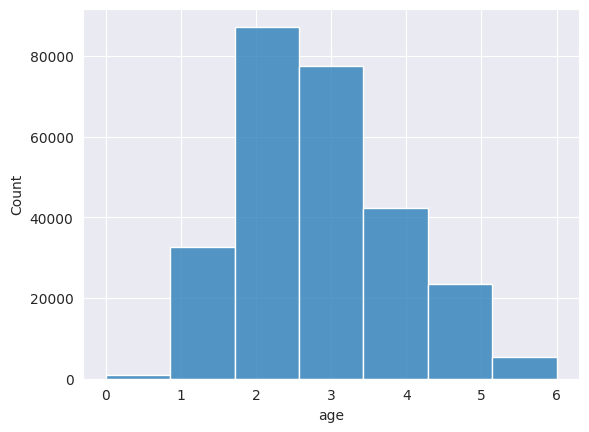

In [ ]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

# удаляем пропущенные значения
df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()

# создаем бакеты по возрасту
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7);

In [ ]:
# по условиям соревнования в тестовых данных нет людей младше 19 лет
# поэтому можем удалить бакет 0
df_trn = df_trn.query('age > 0')

In [ ]:
# разбивка данных на train/validation/test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

## LGBM

In [ ]:
# функция для поиска оптимальных параметров с помощью Optuna
def objective_lgbm(trial, X, y, N_FOLDS, random_state):

    lgbm_params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [2500]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.035275015373286644]),
        # 'num_leaves': trial.suggest_categorical("num_leaves", [1280]),
        # 'max_depth': trial.suggest_categorical("max_depth", [3]),
        # 'min_child_samples': trial.suggest_categorical("min_child_samples", [3200]),
        # 'reg_alpha': trial.suggest_categorical("reg_alpha", [11]),
        # 'reg_lambda': trial.suggest_categorical("reg_lambda", [77]),
        # 'min_split_gain': trial.suggest_categorical("min_split_gain", [15]),
        # 'subsample': trial.suggest_categorical("subsample", [0.5293493678270612]),
        # 'subsample_freq': trial.suggest_categorical("subsample_freq", [1]),
        # 'colsample_bytree': trial.suggest_categorical("colsample_bytree", [0.4521381101269853]),
        "num_leaves":
        trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth":
        trial.suggest_int("max_depth", 3, 12),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 100, 50000, step=100),
        "reg_alpha":
        trial.suggest_int("reg_alpha", 0, 100),
        "reg_lambda":
        trial.suggest_int("reg_lambda", 0, 100),
        "min_split_gain":
        trial.suggest_int("min_split_gain", 0, 20),
        "subsample":
        trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "num_classes":
        trial.suggest_categorical("num_classes", [6]),
        "objective":
        trial.suggest_categorical("objective", ["multiclass"]),
        "class_weight":
        trial.suggest_categorical("class_weight", ["balanced"]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc_mu")

        model = LGBMClassifier(**lgbm_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc_mu",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        preds_proba = model.predict_proba(X_test)
        cv_predicts[idx] = m.roc_auc_score(y_test,
                                           preds_proba,
                                           multi_class='ovo')

        return np.mean(cv_predicts)

In [ ]:
# поиск оптимальных параметров
study_lgbm = optuna.create_study(direction='maximize', study_name='LGBM_01')


def func(trial):
    return objective_lgbm(trial,
                          X_train,
                          y_train,
                          N_FOLDS=N_FOLDS,
                          random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(func, n_trials=20, show_progress_bar=True)

[I 2023-04-08 08:59:14,439] A new study created in memory with name: LGBM_01


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
study_lgbm.best_params

{'n_estimators': 2500,
 'learning_rate': 0.035275015373286644,
 'num_leaves': 2380,
 'max_depth': 6,
 'min_child_samples': 4900,
 'reg_alpha': 21,
 'reg_lambda': 44,
 'min_split_gain': 2,
 'subsample': 0.9376162941244078,
 'subsample_freq': 1,
 'colsample_bytree': 0.6874978844785493,
 'num_classes': 6,
 'objective': 'multiclass',
 'class_weight': 'balanced',
 'random_state': 42}

In [ ]:
lgbm_params_age = {'n_estimators': 2500,
 'learning_rate': 0.035275015373286644,
 'num_leaves': 2380,
 'max_depth': 6,
 'min_child_samples': 4900,
 'reg_alpha': 21,
 'reg_lambda': 44,
 'min_split_gain': 2,
 'subsample': 0.9376162941244078,
 'subsample_freq': 1,
 'colsample_bytree': 0.6874978844785493,
 'num_classes': 6,
 'objective': 'multiclass',
 'class_weight': 'balanced',
 'random_state': 42}

In [ ]:
# обучаем LGBM на лучших найденных параметрах
%%time
lgbm_age = LGBMClassifier(**study_lgbm.best_params)
eval_set = [(X_val, y_val)]

lgbm_age.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             early_stopping_rounds=100,
             verbose=False)

CPU times: user 1h 1min 33s, sys: 5.54 s, total: 1h 1min 39s
Wall time: 16min 43s


LGBMClassifier(class_weight='balanced', colsample_bytree=0.6874978844785493,
               learning_rate=0.035275015373286644, max_depth=6,
               min_child_samples=4900, min_split_gain=2, n_estimators=2500,
               num_classes=6, num_leaves=2380, objective='multiclass',
               random_state=42, reg_alpha=21, reg_lambda=44,
               subsample=0.9376162941244078, subsample_freq=1)

In [ ]:
# проверим не переобучилась ли наша модель
check_overfitting_multiclass(lgbm_age, X_train, y_train, X_test,
                             y_test)

f1-weighted train = 0.463
f1-weighted test = 0.378
delta = 22.76%


In [ ]:
print(
    m.classification_report(
        y_test,
        lgbm_age.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.38      0.67      0.48      6528
       26-35       0.52      0.37      0.43     17454
       36-45       0.44      0.29      0.35     15497
       46-55       0.30      0.29      0.29      8489
       56-65       0.24      0.43      0.31      4716
         66+       0.11      0.29      0.16      1101

    accuracy                           0.38     53785
   macro avg       0.33      0.39      0.34     53785
weighted avg       0.41      0.38      0.38     53785



In [ ]:
# получим итоговые метрики на тестовых данных
y_pred = lgbm_age.predict(X_test)
y_score = lgbm_age.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='LGBM_Optuna',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.237250,0.239119,0.292757,0.239119,0.218909,0.246096,1.660580
1,CatBoost_Baseline,0.675669,0.365381,0.320267,0.365381,0.224303,0.365381,0.216226,0.321252,1.463261
2,RandomForest_Baseline,0.634683,0.347439,0.262835,0.347439,0.211312,0.347439,0.201186,0.303809,1.712283
3,LGBM_Baseline_embeddings,0.754989,0.350395,0.315773,0.350395,0.379041,0.350395,0.314327,0.355704,1.466697
4,CatBoost_Baseline_embeddings,0.779631,0.445366,0.437807,0.445366,0.318597,0.445366,0.332238,0.425856,1.282605
0,LGBM_Optuna,0.767458,0.375123,0.332053,0.375123,0.390934,0.375123,0.338180,0.377554,1.405721


## Catboost

In [ ]:
from catboost import Pool

# функция для поиска оптимальных параметров с помощью Optuna
def objective_cat(trial, X, y, N_FOLDS, random_state):

    cat_params = {
        # "iterations": trial.suggest_categorical("iterations", [i for i in range(500, 3101, 100)]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "iterations":
        trial.suggest_categorical("iterations", [2600]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.04580986967296549]),
        "max_depth":
        trial.suggest_int("max_depth", 4, 10),
        "colsample_bylevel":
        trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
        "random_strength":
        trial.suggest_uniform('random_strength', 10, 50),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS", "No"]),
        "border_count":
        trial.suggest_categorical('border_count', [128, 254]),
        "grow_policy":
        trial.suggest_categorical('grow_policy',
                                  ["SymmetricTree", "Depthwise", "Lossguide"]),
        "od_wait":
        trial.suggest_int('od_wait', 500, 2000),
        "leaf_estimation_iterations":
        trial.suggest_int('leaf_estimation_iterations', 1, 15),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 100)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample",
                                                      0.1,
                                                      1,
                                                      log=True)

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train)
        eval_data = Pool(data=X_test, label=y_test)

        model = CatBoostClassifier(**cat_params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds_proba = model.predict_proba(X_test)
        cv_predicts[idx] = m.roc_auc_score(y_test,
                                           preds_proba,
                                           multi_class='ovo')

        return np.mean(cv_predicts)

In [ ]:
# поиск оптимальных параметров
%%time
study_cat = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_01")


def func(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)


study_cat.optimize(func, n_trials=10, show_progress_bar=True)

[I 2023-03-27 06:52:45,011] A new study created in memory with name: Cat_01


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-27 07:45:01,762] Trial 0 finished with value: 0.15248433893291924 and parameters: {'iterations': 2600, 'learning_rate': 0.04580986967296549, 'max_depth': 8, 'colsample_bylevel': 0.9203709920711644, 'l2_leaf_reg': 55.01141456996415, 'random_strength': 30.219239919339135, 'bootstrap_type': 'No', 'border_count': 128, 'grow_policy': 'Depthwise', 'od_wait': 741, 'leaf_estimation_iterations': 11, 'random_state': 42}. Best is trial 0 with value: 0.15248433893291924.
[I 2023-03-27 07:46:52,364] Trial 1 finished with value: 0.1 and parameters: {'iterations': 2600, 'learning_rate': 0.04580986967296549, 'max_depth': 6, 'colsample_bylevel': 0.6925156750752623, 'l2_leaf_reg': 83.95289455446628, 'random_strength': 20.004398809770827, 'bootstrap_type': 'Bayesian', 'border_count': 254, 'grow_policy': 'Lossguide', 'od_wait': 551, 'leaf_estimation_iterations': 10, 'random_state': 42, 'bagging_temperature': 96.8113103460146}. Best is trial 0 with value: 0.15248433893291924.
[I 2023-03-27 09:24

In [ ]:
study_cat.best_params

{'iterations': 2600,
 'learning_rate': 0.04580986967296549,
 'max_depth': 7,
 'colsample_bylevel': 0.6502841606511838,
 'l2_leaf_reg': 93.87518619376878,
 'random_strength': 38.67772771530471,
 'bootstrap_type': 'Bernoulli',
 'border_count': 128,
 'grow_policy': 'SymmetricTree',
 'od_wait': 846,
 'leaf_estimation_iterations': 4,
 'random_state': 42,
 'subsample': 0.7265555309408829}

In [ ]:
# обучаем CatBoost на лучших найденных параметрах
%%time
cat_features = X_train.select_dtypes('category').columns.tolist()
cat_age = CatBoostClassifier(**study_cat.best_params, cat_features=cat_features)
eval_set = [(X_val, y_val)]

cat_age.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=False)

CPU times: user 4h 13min 11s, sys: 6min 39s, total: 4h 19min 50s
Wall time: 1h 12min 44s


In [ ]:
# проверим модель на переобучение
check_overfitting_multiclass(cat_age, X_train, y_train, X_test, y_test)

f1-weighted train = 0.530
f1-weighted test = 0.429
delta = 23.67%


In [43]:
print(
    m.classification_report(
        y_test,
        cat_age.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.54      0.32      0.40      6528
       26-35       0.49      0.64      0.55     17454
       36-45       0.40      0.53      0.46     15497
       46-55       0.39      0.22      0.28      8489
       56-65       0.41      0.20      0.27      4716
         66+       0.43      0.02      0.04      1101

    accuracy                           0.45     53785
   macro avg       0.44      0.32      0.33     53785
weighted avg       0.45      0.45      0.43     53785



In [42]:
# получим итоговые метрики на тестовых данных
y_pred = cat_age.predict(X_test)
y_score = cat_age.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='CatBoost_Optuna',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.237250,0.239119,0.292757,0.239119,0.218909,0.246096,1.660580
1,CatBoost_Baseline,0.675669,0.365381,0.320267,0.365381,0.224303,0.365381,0.216226,0.321252,1.463261
2,RandomForest_Baseline,0.634683,0.347439,0.262835,0.347439,0.211312,0.347439,0.201186,0.303809,1.712283
3,LGBM_Baseline_embeddings,0.754989,0.350395,0.315773,0.350395,0.379041,0.350395,0.314327,0.355704,1.466697
4,CatBoost_Baseline_embeddings,0.779631,0.445366,0.437807,0.445366,0.318597,0.445366,0.332238,0.425856,1.282605
0,LGBM_Optuna,0.767458,0.375123,0.332053,0.375123,0.390934,0.375123,0.338180,0.377554,1.405721
0,CatBoost_Optuna,0.782471,0.449047,0.443242,0.449047,0.319530,0.449047,0.332890,0.428523,1.277642


Вывод: самые высокие метрики у catboost с эмбеддингами

In [ ]:
metrics_age.to_csv('metrics/metrics_age_tuned.csv', index=False)

# Submission

## Gender

Для итогового предсказания по полу будем использовать CatBoost с кросс-валидацией со следующими параметрами

In [ ]:
cat_gender_best = {
    'iterations': 3000,
    'learning_rate': 0.051418504137325544,
    'max_depth': 4,
    'colsample_bylevel': 0.7594434568905333,
    'l2_leaf_reg': 57.13098420673366,
    'random_strength': 30.89358906898957,
    'bootstrap_type': 'No',
    'border_count': 128,
    'grow_policy': 'Lossguide',
    'od_wait': 1886,
    'leaf_estimation_iterations': 15,
    'eval_metric': 'AUC',
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

In [ ]:
# итоговый датафрейм для обучения
df_train_cat = targets.merge(df, how='inner', on=['user_id']) \
                      .merge(url_emb, how='inner', on='user_id') \
                      .merge(city_emb, how='inner', on=['user_id']) \
                      .merge(reg_emb, how='inner', on=['user_id']) \
                      .merge(model_emb, how='inner', on=['user_id'])

df_train_cat = df_train_cat[df_train_cat['is_male'] != 'NA']
df_train_cat = df_train_cat.dropna()
df_train_cat['is_male'] = df_train_cat['is_male'].map(int)
df_train_cat['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [ ]:
# датафрейм, для которого будем делать предсказания
id_to_sub_data = id_to_submit.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(city_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(model_emb, how='inner', on=['user_id']) \
    .drop('user_id', axis=1)

In [ ]:
# train/test split
%%time
X_train = df_train_cat.drop(['user_id', 'age', 'is_male'], axis=1)
y_train = df_train_cat['is_male']

X_test = id_to_sub_data

# значение для scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

CPU times: user 87.4 ms, sys: 123 ms, total: 210 ms
Wall time: 210 ms


In [ ]:
# кросс-валидация с предсказанием на тестовых данных
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

cat_features = X_train.select_dtypes('category').columns.tolist()

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(cat_features=cat_features, **cat_gender_best)

    model.fit(X_train_, y_train_, verbose=False)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)[:, 1]
    cv_predicts_val[idx] = m.roc_auc_score(y_val_, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.8473140732028428 

id = 1 0.8489847350187312 

id = 2 0.8430018692300713 

id = 3 0.8493735341517681 

id = 4 0.8462049992990305 

0.8469758421804888


In [ ]:
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [ ]:
# сохраним предсказания в итоговое решение
id_to_submit['is_male'] = test_pred_proba[:, 1]
id_to_submit

,user_id,is_male
221301,221301,0.969222
31271,31271,0.531237
211594,211594,0.564567
253119,253119,0.516738
192578,192578,0.802211
...,...,...
145307,415284,0.541976
145308,415285,0.652584
145309,415286,0.603176
145312,415306,0.649970


## Age

Для итогового предсказания бакета по возрасту будем использовать CastBoost с кросс-валидацией со следующими параметрами

In [ ]:
cat_age_params = {
    'iterations': 2600,
    'learning_rate': 0.04580986967296549,
    'max_depth': 7,
    'colsample_bylevel': 0.6502841606511838,
    'l2_leaf_reg': 93.87518619376878,
    'random_strength': 38.67772771530471,
    'bootstrap_type': 'Bernoulli',
    'border_count': 128,
    'grow_policy': 'SymmetricTree',
    'od_wait': 846,
    'leaf_estimation_iterations': 4,
    'random_state': 42,
    'subsample': 0.7265555309408829
}

In [ ]:
def age_bucket(x):
    """Функция для создания бакетов по возрасту"""
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

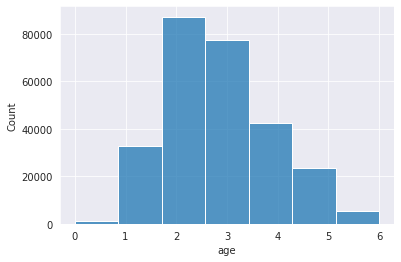

In [ ]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

# удаляем пропущенные значения
df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()

# создаем бакеты по возрасту
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7);

In [ ]:
# по условиям соревнования в тестовых данных нет людей младше 19 лет
# поэтому можем удалить бакет 0
df_trn = df_trn.query('age > 0')

In [ ]:
# датафрейм, для которого будем делать предсказание
id_to_sub_data = id_to_submit.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(city_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(model_emb, how='inner', on=['user_id']) \
    .drop('user_id', axis=1)

In [ ]:
# train/test split
%%time
X_train = df_trn.drop(['user_id', 'age', 'is_male'], axis=1)
y_train = df_trn['age']

X_test = id_to_sub_data

CPU times: user 134 ms, sys: 129 ms, total: 264 ms
Wall time: 265 ms


In [ ]:
# кросс-валидация с предсказанием на тестовых данных
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

cat_features = X_train.select_dtypes('category').columns.tolist()

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(cat_features=cat_features, **cat_age_params)

    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val_, y_val_)],
              early_stopping_rounds=100,
              verbose=0)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)
    cv_predicts_val[idx] = m.roc_auc_score(y_val_,
                                           preds_val_proba,
                                           multi_class='ovo')

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.7700369031021982 

id = 1 0.7700856722776952 

id = 2 0.7695656046299223 

id = 3 0.7695729190339798 

id = 4 0.7688620634266969 

0.7696246324940985


In [ ]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]

In [ ]:
# сохраним предсказания в итоговое решение
id_to_submit['age'] = test_pred
id_to_submit

,user_id,is_male,age
0,221301,0.969222,2
1,31271,0.531237,3
2,211594,0.564567,2
3,253119,0.516738,2
4,192578,0.802211,2
...,...,...,...
144719,415284,0.541976,2
144720,415285,0.652584,2
144721,415286,0.603176,3
144722,415306,0.649970,2


In [ ]:
# сохраним итоговое решение
import datetime

cur_time = str(datetime.datetime.now()).replace(' ', '_')[:16]
sub_name = 'submissions/submission_' + cur_time + '.csv'
id_to_submit.to_csv(sub_name, index=False)

Leaderboard score: 1,5629284013

Итоговое место: 210 из 510